# Overlapping communities and statistical inference of communities

<div style="display: flex; align-items: center;">
    <a target="_blank" href="https://colab.research.google.com/github/yy/netsci-course/blob/master/docs/m07-communities/lab07-2.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" style="vertical-align: -8px; margin-right: 10px;" />
        Open this notebook in Google Colab
    </a>
</div>


<div style="display: flex; align-items: center;">
    <a href="https://raw.githubusercontent.com/yy/netsci-course/master/docs/m07-communities/lab07-2.ipynb" download>
        <img src="http://yyahn.com/netsci-course/images/download_icon.png" style="vertical-align: -8px; margin-right: 10px;" />
        Download this notebook (File -> Save As)
    </a>
</div>

## What's wrong with modularity-maximization or similar methods?

They are not necessarilly wrong! Those methods we tested last time may work perfectly fine for many networks and the community structure that you are interested in. However, there is an important implicit assumption shared by most community detection methods. That is, the communities are _disjoint_ or _non-overlapping_, which  means that each node belongs to exactly one community.

Imagine the social network around you. Do you belong to exactly one community? Probably not, because you have friends, family, and colleagues in many different contexts (a figure from [Palla et al., 2005](https://www.nature.com/articles/nature03607)). 

<img src="https://yyiki.s3.us-east-2.amazonaws.com/public/imgs/palla2005nature_overlapping_community_illustration.jpg" width="400" />

Moreover, this is not only true for yourself, but also for all other nodes in the network. If this is how the network is structured, then community detection methods that assume disjoint communities will not be able to capture the true community structure of the network.

<img src="https://yyiki.s3.us-east-2.amazonaws.com/public/imgs/bagrow_pervasively_overlapping_community_illustration.png" width="400" />

Another way to think about this situation is to use a bipartite network of people and communities. There are many people and many communities and each person can belong to multiple communities. Then, the social network we see is a projection of this bipartite network. 

Let's look at a simple example. Here, there are two communities. Most people belong to only one of them, but person "D" belongs to both. 

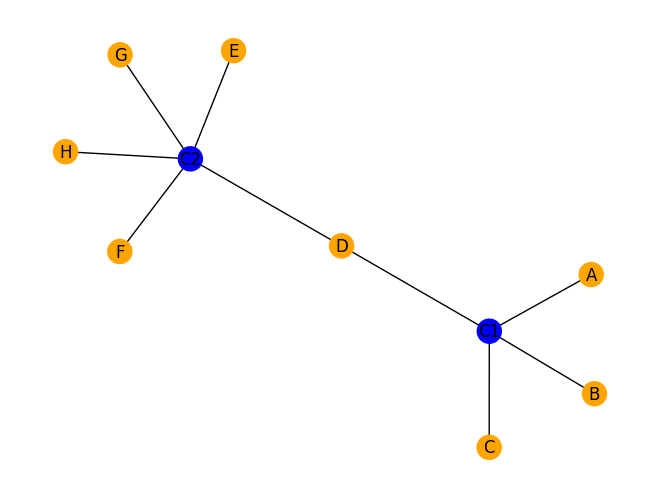

In [1]:
import networkx as nx

people = ["A", "B", "C", "D", "E", "F", "G", "H"]
communities = ["C1", "C2"]
membership = {
    "A": ["C1"],
    "B": ["C1"],
    "C": ["C1"],
    "D": ["C1", "C2"],
    "E": ["C2"],
    "F": ["C2"],
    "G": ["C2"],
    "H": ["C2"],
}

B = nx.Graph()
B.add_nodes_from(people, bipartite=0)
B.add_nodes_from(communities, bipartite=1)
B.add_edges_from(
    [(person, community) for person in people for community in membership[person]]
)

nx.draw(
    B,
    with_labels=True,
    node_color=["orange" if B.nodes[n]["bipartite"] == 0 else "blue" for n in B.nodes],
)

If you project this bipartite network to the network of people, then you will see a network with two overlapping communities. They overlap at node "D". 

**Q: perform a bipartite projection of B to get the network of people P. And then draw the network**

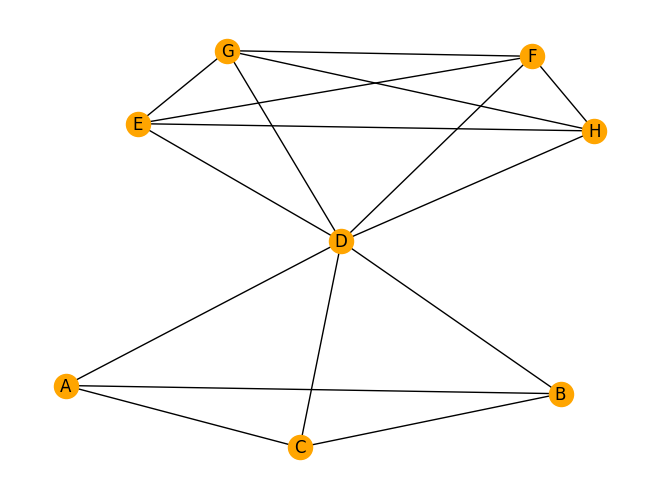

In [2]:
# YOUR SOLUTION HERE

## So, how can we identify strongly overlapping communities?

If you apply Louvain method or any other method that assumes disjoint communities to this network, they will have to put node "D" into either one of the communities, which is not ideal. A common approach to overlapping community detection is to _allow_ "fuzzy" boundaries between communities. There are many ways to do this, and in this simple example, this type of fuzzy overlapping community detection method will work perfectly fine. 

But, while keeping the example very simple, let's think about more complex cases where where the overlap is pervasive and each node can belong to multiple communities. Then the "fuzzy" community detection approach may not work well, again due to the limiting assumption that the communities are _almost_ disjoint. 

Going beyond this "fuzzy" assumption, we can think about "pervasive overlapping communities" where each and every node can belong to multiple communities. This is the most challenging case, and it can also be the most realistic case for many real-world networks. There are, again, many ways to do this, but let's try a conceptually simple and illustrative method based on the concept of "link communities" ([Paper](https://www.nature.com/articles/nature09182)), where we think about the communities of _links_ (edges) rather than nodes. It also happened to be my method as well. 🙈 

The key idea is that 'disjoint link communities' is a better approximation than 'disjoint node communities'. Even when every node belongs to multiple communities, the links between nodes can be partitioned into disjoint communities very well. Instead of trying to put nodes into communities, we put links into communities. 

The method first constructs a weighted "line graph" where each edge in the original network becomes a node and two nodes are connected if the corresponding edges share a node. The weights of the edges in the line graph are calculated based on the shared neighbors of the corresponding edges. Then, it applies a hierarchical clustering to the nodes of this line graph. 

Let's try. First, activate your virtual environment and install the package to your virtual environment by running the following command. 

```bash
pip install git+https://github.com/Nathaniel-Rodriguez/linkcom.git
```

If you use [`uv`](https://github.com/astral-sh/uv), you can install it by running the following command. 

```bash
uv pip install "linkcom @ git+https://github.com/Nathaniel-Rodriguez/linkcom.git"
```

Then we can import and run the method as following. 

In [4]:
import linkcom

e2c, S, D, Dlist = linkcom.cluster(P)

clustering...
computing similarities...
# D_max = 1.000000
# S_max = 0.125000


The `e2c` stores the edge-to-community mapping. It is a dictionary where the keys are the edges and the values are the community IDs. 



In [5]:
e2c

{('F', 'G'): 14,
 ('A', 'D'): 6,
 ('A', 'C'): 6,
 ('C', 'D'): 6,
 ('E', 'G'): 14,
 ('D', 'F'): 14,
 ('A', 'B'): 6,
 ('D', 'H'): 14,
 ('B', 'D'): 6,
 ('B', 'C'): 6,
 ('D', 'G'): 14,
 ('G', 'H'): 14,
 ('D', 'E'): 14,
 ('F', 'H'): 14,
 ('E', 'F'): 14,
 ('E', 'H'): 14}

You can see that there are two communities 3 and 15. Now we can set edge attributes based on the community IDs. 

In [6]:
nx.set_edge_attributes(P, e2c, "linkcom")

**Q: Can you draw the network again with the edge colors based on the community IDs?**

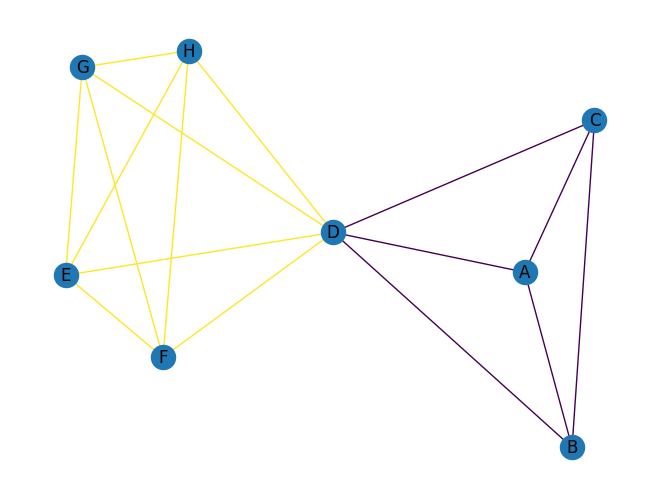

In [7]:
# YOUR SOLUTION HERE

Can you see now why link community approach can detect highly overlapping communities? 

**Q: Now, download a small network where you expect to see pervasively overlapping community strcuture and try the link community detection method. Visualize the network by coloring the edges using the found community ID.**

In [7]:
# YOUR SOLUTION HERE

## Statistical inference approach to community detection

Pretty much all methods that we have discussed in the class so far are based on some heuristics and/or optimization algorithms. Although they may work perfectly fine for many cases, there is another powerful approach that we want to know about. That is the statistical inference approach to community detection. In this approach, we can be more explicit and flexible about the exact nature of the community structure that we are looking for. We can also quantify the uncertainty of the community structure that we infer and compare different community structures in a principled way.

### Stochastic block models

The key idea is that we can think of the community structure as a _generative model_ of the network. That is, we assume that the network is generated by some underlying community structure and we want to infer this community structure from the network. If we have a probabilistic model of the network, we can use the observed network to infer the parameters of the model (Bayesian inference). 

The most fundamental model is the stochastic block model (SBM). In this model, the network is generated by the following process.

1. Each node belongs to one of the $K$ communities.
2. The probability of an edge between two nodes depends only on the community assignments of the two nodes.

Let's try an example. Let's have a network with 20 nodes and 2 communities. Nodes 0-9 belong to community 0 and nodes 10-19 belong to community 1. The probability of an edge between two nodes is 0.7 if they belong to the same community and 0.05 if they belong to different communities.

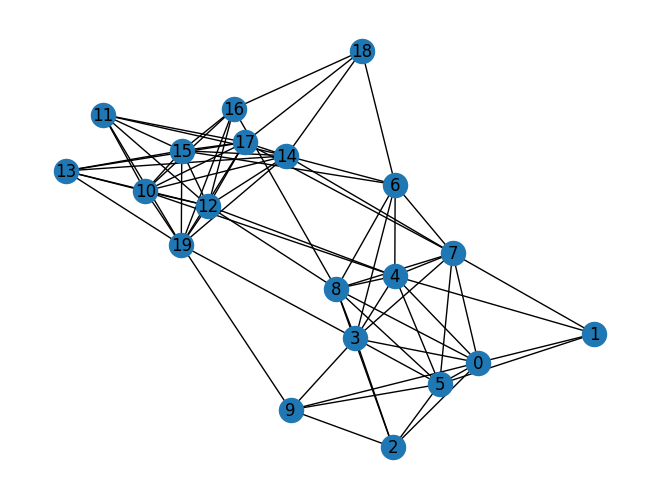

In [8]:
import random

G = nx.Graph()
G.add_nodes_from(range(20))

# add community id as node attribute
for i in range(10):
    G.nodes[i]["community"] = 0
for i in range(10, 20):
    G.nodes[i]["community"] = 1

# Add edges between nodes with probability 0.7 if they are in the same community, and 0.05 otherwise
# YOUR SOLUTION HERE

nx.draw(G, with_labels=True)

Congratulations! Now you implemented a simple stochastic block model. This model generated a network given a set of parameters. Assuming that we fix the total number of nodes, what are the parameters that we set? 

1. The number of communities $K$
2. The community assignments of the nodes $z_i$ ($ 1 \times N$ vector)
3. The edge probabilities $p_{ij}$ ($K \times K$ matrix)

### Bayes' theorem

So how does this help us to detect communities? To understand this, let's look at the Bayes theorem:

$$ P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)} $$

Here, $\theta$ is the set of parameters of the model and $D$ is the observed data. If we ignore $P(D)$ and $P(\theta)$ for a moment, we get the following. 

$$ P(\theta | D) \propto P(D | \theta) $$

What this means is that the probability of any set of parameter given what the data tells us ($P(\theta | D)$) is proportional to the probability that the data is _generated_ by the model with the parameters ($P(D | \theta)$). This is the key idea of the Bayesian inference. If we have a generative model that can generate data from a set of parameters, then we can evaluate $P(D | \theta)$, and this can in turn tell us how good the parameters are given the data $P(\theta | D)$. 

Here $P(D | \theta)$ is called the _likelihood_ of the parameters given the data and $P(\theta | D)$ is called the _posterior probability_ of the parameters given the data.

### Maximum likelihood Coin flips 

To understand this better, let's take a super quick detore to the coin flips. Here, 

1. Our data $D$ is the sequence of 10 coin flips: "H", "T", "H", "H", "T", "T", "H", "T", "H", "H". 
2. Our model is the Bernoulli distribution with the parameter $\theta$ which is the probability of getting "H".

Then, the likelihood ($P(D | \theta)$) is the probability of getting the observed sequence of coin flips given the parameter $\theta$. We can calculate this directly. 

In [9]:
coin_flip_data = ["H", "T", "H", "H", "T", "T", "H", "T", "H", "H"]
theta = 0.1  # parameter

# likelihood
likelihood = 1.0
for x in coin_flip_data:
    if x == "H":
        likelihood *= theta
    else:
        likelihood *= 1 - theta

likelihood

6.561000000000003e-07

We can make it as a function. 

In [10]:
import numpy as np


def coin_flip_likelihood(theta, data):
    return np.prod([theta if x == "H" else 1 - theta for x in data])

We can evaluate the likelihood for several values of $\theta$.

In [11]:
for theta in np.linspace(0, 1, 10):
    print(theta, coin_flip_likelihood(theta, coin_flip_data))

0.0 0.0
0.1111111111111111 1.1747213274285833e-06
0.2222222222222222 4.4070404799312956e-05
0.3333333333333333 0.0002709614049348847
0.4444444444444444 0.0007342008296428648
0.5555555555555556 0.0011471887963169767
0.6666666666666666 0.0010838456197395387
0.7777777777777777 0.0005398624587915844
0.8888888888888888 7.518216495542947e-05
1.0 0.0


Or, plot a likelihood curve.

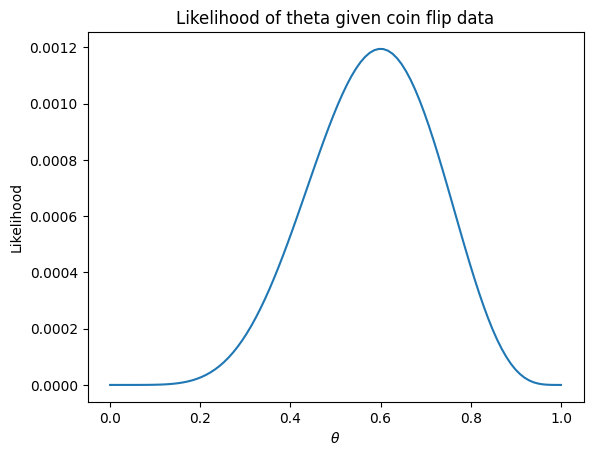

In [12]:
# plot a likelihood curve
import matplotlib.pyplot as plt

thetas = np.linspace(0, 1, 100)

# YOUR SOLUTION HERE

plt.xlabel("$\\theta$")
plt.ylabel("Likelihood")
plt.title("Likelihood of theta given coin flip data")
plt.show()

Can you find the best parameter now? How? 

Yes, when the likelihood is maximized, we get the best parameter according to this reasoning. This is called the _maximum likelihood estimation_ (MLE) and it is one of the most common statistical inference method. 

### Back to SBM

Although the community detection problem with SBM is more complex, involving many more parameters, the basic idea is the same. Let's go back to the graph that we generated. 

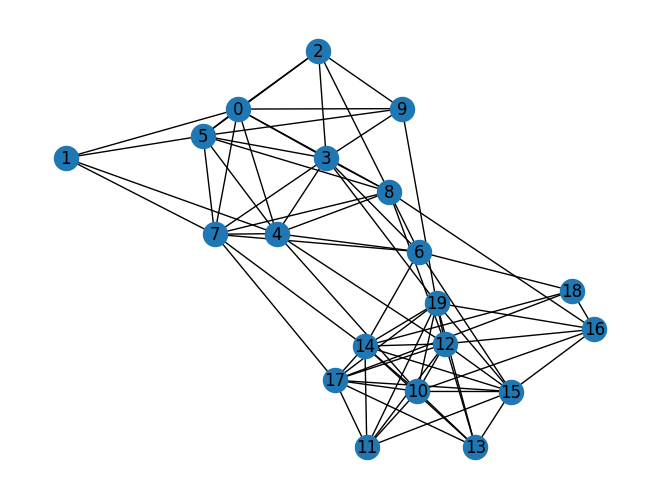

In [13]:
nx.draw(G, with_labels=True)

To simplify things, let's assume that we fix the number of communities $K=2$ and the community assignments $z_i$ are known. Let's also assume that $p_{00} = p_{11}$ and $p_{01} = p_{10}$. Then, the only parameters that we need to infer are the edge probabilities $p_{ij}$, namely the two numbers $p_{00}$ and $p_{01}$.

Note that given the data (the observed network) and parameters, we can calculate the likelihood. This is the probability of observing the network given the parameters. For instance, given a node pair $(i, j)$, the probability of observing an edge between them is $p_{z_i z_j}$ and the probability of **not** observing an edge between them is $1 - p_{z_i z_j}$.

Then, the probability of observing the entire network is the product of these probabilities for all node pairs.

In [14]:
from itertools import combinations

p00 = 0.7
p01 = 0.05

# likelihood
likelihood = 1.0
for i, j in combinations(G.nodes, 2):
    # YOUR SOLUTION HERE

likelihood

3.676841317675112e-40

Btw, do you note that the likelihood is extremely small? As we multiply many small numbers (probabilities), the result becomes extremely small. This can lead to all kinds of numerics problems and we often use the log-likelihood instead. Using log-likelihood makes the multiplication into addition and the numbers are much more manageable.

Let's write a super simple function to calculate the log-likelihood of the SBM.

In [15]:
def sbm_likelihood(G, p00, p01):
    log_likelihood = 0.0
    for i, j in combinations(G.nodes, 2):
        # YOUR SOLUTION HERE
    return log_likelihood


sbm_likelihood(G, 0.7, 0.05)

-90.80134967375167

Now we can vary a parameter to see how the log-likelihood changes.

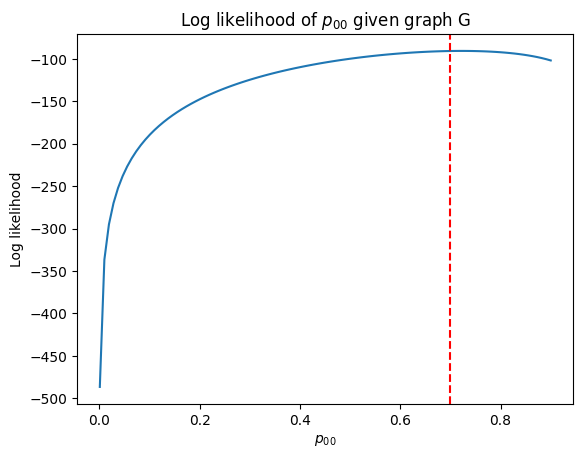

In [16]:
p00 = np.linspace(0.001, 0.9, 100)
p01 = 0.05
likelihoods = [sbm_likelihood(G, p00, p01) for p00 in p00]
plt.plot(p00, likelihoods)
plt.xlabel("$p_{00}$")
plt.ylabel("Log likelihood")
plt.title("Log likelihood of $p_{00}$ given graph G")
# draw a vertical line at 0.7
plt.axvline(0.7, color="red", linestyle="--")
plt.show()

**Q: try with p01.**

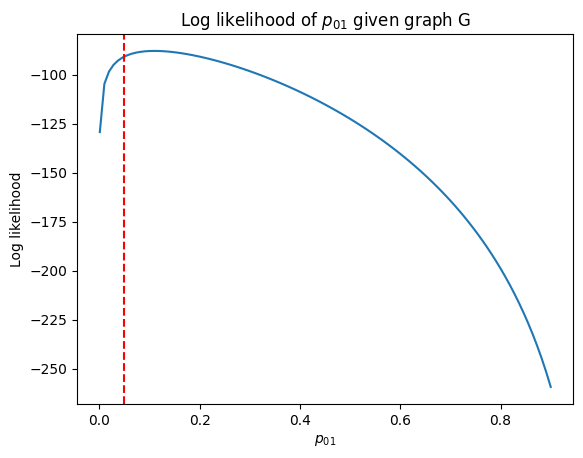

In [17]:
p00 = 0.7
p01_list = np.linspace(0.001, 0.9, 100)

# YOUR SOLUTION HERE

It's cool to see that the log-likelihood is maximized roughly around the true value of the parameter!

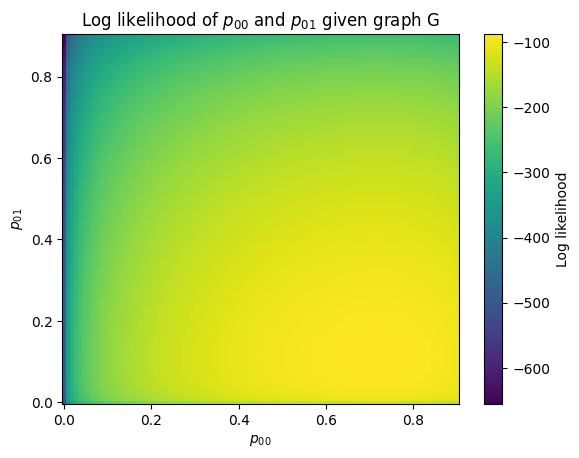

In [18]:
# We can vary both. 
p00_list = np.linspace(0.001, 0.9, 100)
p01_list = np.linspace(0.001, 0.9, 100)
X, Y = np.meshgrid(p00_list, p01_list)
likelihoods = [[sbm_likelihood(G, p00, p01) for p00 in p00_list] for p01 in p01_list]

# colormap
plt.pcolor(X, Y, likelihoods)
plt.colorbar(label="Log likelihood")
plt.xlabel("$p_{00}$")
plt.ylabel("$p_{01}$")
plt.title("Log likelihood of $p_{00}$ and $p_{01}$ given graph G")
plt.show()

As you can see, the true parameter value is close to the maximum likelihood estimate, as it should be! 

This is the basic idea of the inference from a generative model. If your model is good, then the best parameters may be those that explain the data best. Although there are much more complexity beyond this simple maximum likelihood estimation, this is the basic idea that you want to really understand. Being able to generate a data from a set of parameters allows us to evaluate how good the parameters are given the data, which in turn allows us to identiy good parameter values given data. 

**Q: Can you identify the best parameters ($p_{00}$ and $p_{01}$) for the network that we generated, by finding the parameters that maximize the log likelihood?**

In [19]:
p00_list = np.linspace(0.001, 0.9, 100)
p01_list = np.linspace(0.001, 0.9, 100)
X, Y = np.meshgrid(p00_list, p01_list)
likelihoods = [[sbm_likelihood(G, p00, p01) for p00 in p00_list] for p01 in p01_list]
likelihoods = np.array(likelihoods)

# YOUR SOLUTION HERE

p00_max: 0.718
p01_max: 0.110
max_log_likelihood: -87.83062259736532


Let's generate a network with these paraemters and compare the true network and the inferred network side by side. Note that we can generate as many networks as we want from the same MLE parameters. That means we can do all kinds of measurements on the generated networks and estimate the uncertainty of the measurements! This is one of the cool powers of the statistical inference approach!

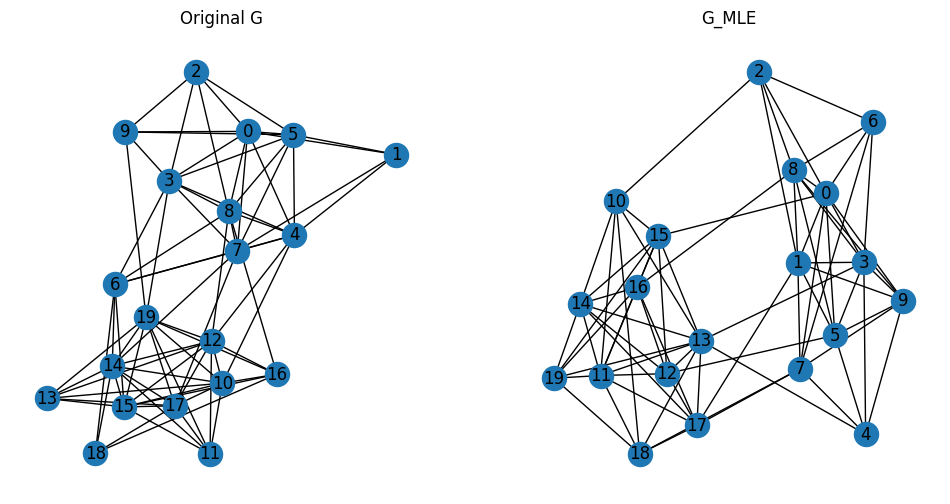

In [20]:
G_MLE = nx.Graph()
G_MLE.add_nodes_from(range(20))

# add community id as node attribute
for i in range(10):
    G_MLE.nodes[i]["community"] = 0
for i in range(10, 20):
    G_MLE.nodes[i]["community"] = 1

# Create G_MLE and then draw both G and G_MLE

# YOUR SOLUTION HERE